# About this project:

This project aims to train a neural network model to identify the presence of COVID-19 from images of Chest X-Rays. A model that works well would be useful for accelerating the identification of infected individuals, especially in countries where hospitals are overwhelmed and can benefit from streamlining the testing process.


## Dataset information:


The dataset was downloaded from Kaggle: https://www.kaggle.com/praveengovi/coronahack-chest-xraydataset


## Content

The dataset contains ~5800 jpeg images of Chest X-Rays of Healthy patients, as well as patients affected with Pneumonia. The pneumonia X-Rays contain cases of bacterial infections as well as viral infections, such as SARS (Severe Acute Respiratory Syndrome ) ,Streptococcus & ARDS (Acute Respiratory Distress Syndrome).


## Acknowledgements

This analysis is made possible by the dataset compiled by Joseph Paul Cohen. Postdoctoral Fellow, Mila, University of Montreal.

Original Source :- https://github.com/ieee8023/covid-chestxray-dataset

# Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import PIL
import tensorflow as tf
from sklearn.metrics import plot_confusion_matrix, confusion_matrix

#For organizing image folders
import shutil
import os
from sklearn.model_selection import train_test_split

#Hyperparameter tuning
import kerastuner as kt
import math

#Model building
from tensorflow import keras
from tensorflow.keras import layers
from keras import Sequential
from keras.layers import Conv2D, Dense, Flatten, Dropout, BatchNormalization, MaxPool2D
from keras.models import Sequential, load_model
from keras.metrics import AUC, Precision, Recall
from keras.optimizers import Adam

# Ensure we use GPU for faster neural network training

Note: For this notebook we create a virtual environment with the tensorflow-gpu package instead of the usual tensorflow. This ensures GPU usage for training instead of CPU. 

Documentation: https://www.tensorflow.org/install/gpu

In [2]:
from tensorflow.python.client import device_lib

print('Making sure GPU is available:')
print("GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print('GPU Name:', tf.config.list_physical_devices('GPU'))

Making sure GPU is available:
GPUs Available:  1
GPU Name: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


GPU usage resulted in ~40s per epoch compared to 26 mins with CPU!

# Import data

In [3]:
# os.mkdir('./Data/')

df = pd.read_csv('./Data/Chest_xray_Corona_Metadata.csv', index_col = 0)

df_train = df[df['Dataset_type'] == 'TRAIN']
df_test = df[df['Dataset_type'] == 'TEST']

print('Training data shape:', df_train.shape)
print('Testing data shape:', df_test.shape)

#Looking at metadata:

df_train.head()

Training data shape: (5286, 5)
Testing data shape: (624, 5)


,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,IM-0128-0001.jpeg,Normal,TRAIN,NaN,NaN
1,IM-0127-0001.jpeg,Normal,TRAIN,NaN,NaN
2,IM-0125-0001.jpeg,Normal,TRAIN,NaN,NaN
3,IM-0122-0001.jpeg,Normal,TRAIN,NaN,NaN
4,IM-0119-0001.jpeg,Normal,TRAIN,NaN,NaN


In [4]:
#The dataset also contains a csv file of the summary counts:

summary = pd.read_csv('./Data/Chest_xray_Corona_dataset_Summary.csv', index_col = 0)
summary

,Label,Label_1_Virus_category,Label_2_Virus_category,Image_Count
0,Normal,NaN,NaN,1576
1,Pnemonia,Stress-Smoking,ARDS,2
2,Pnemonia,Virus,NaN,1493
3,Pnemonia,Virus,COVID-19,58
4,Pnemonia,Virus,SARS,4
5,Pnemonia,bacteria,NaN,2772
6,Pnemonia,bacteria,Streptococcus,5


Some of the rows have too little data and will simply be dropped from the analysis:

In [5]:
#Drop unwanted rows:
summary.drop(axis = 0, index = [1,4,6])

,Label,Label_1_Virus_category,Label_2_Virus_category,Image_Count
0,Normal,NaN,NaN,1576
2,Pnemonia,Virus,NaN,1493
3,Pnemonia,Virus,COVID-19,58
5,Pnemonia,bacteria,NaN,2772


All the images will be used for analysis except the non-viral, Stress-Smoking images, as there are only 2 of those.

The dataset is also very imbalanced with only 58 images for the COVID-19 category. Class weights will be implemented later on to address the issue.

# Preparing the image data by rearranging the directories:

### Making new folders for Healthy (Pneumonia-free) X-Rays:

In [6]:
#Get list of all filenames

all_filenames_test = os.listdir('./Pictures/test')
all_filenames_train = os.listdir('./Pictures/train')

#Get list of filenames for the 'Normal' or healthy X-rays

normal_filenames_test = list(df_test[df_test['Label'] == 'Normal']['X_ray_image_name'])
normal_filenames_train = list(df_train[df_train['Label'] == 'Normal']['X_ray_image_name'])

print('No. of Normal X-rays (training):',len(normal_filenames_train))
print('No. of Normal X-rays (testing):',len(normal_filenames_test))

No. of Normal X-rays (training): 1342
No. of Normal X-rays (testing): 234


In [7]:
#Move files into new folder (testing)

'''
#os.makedirs('./Pictures/test/normal')


for filename in normal_filenames_test:
    shutil.move(src = './Pictures/test/{}'.format(filename),
                dst = './Pictures/test/normal/{}'.format(filename)
               )
'''
    
#Move files into new folder (training)

'''
os.makedirs('./Pictures/train/normal')

for filename in normal_filenames_train:
    shutil.move(src = './Pictures/train/{}'.format(filename),
                dst = './Pictures/train/normal/{}'.format(filename)
               )               
'''

"\nos.makedirs('./Pictures/train/normal')\n\nfor filename in normal_filenames_train:\n    shutil.move(src = './Pictures/train/{}'.format(filename),\n                dst = './Pictures/train/normal/{}'.format(filename)\n               )               \n"

### Making new folders for Pneumonia (bacterial) infections:

In [8]:
#Get list of filenames for the bacterial infection X-rays

bacteria_filenames_test = list(df_test[df_test['Label_1_Virus_category'] == 'bacteria']['X_ray_image_name'])
bacteria_filenames_train = list(df_train[df_train['Label_1_Virus_category'] == 'bacteria']['X_ray_image_name'])

print('No. of Bacterial Infection X-rays (training):',len(bacteria_filenames_train))
print('No. of Bacterial Infection X-rays (testing):',len(bacteria_filenames_test))

No. of Bacterial Infection X-rays (training): 2535
No. of Bacterial Infection X-rays (testing): 242


In [9]:
#Move files into new folder (testing)

'''
os.makedirs('./Pictures/test/bacteria')


for filename in bacteria_filenames_test:
    shutil.move(src = './Pictures/test/{}'.format(filename),
                dst = './Pictures/test/bacteria/{}'.format(filename)
               )

'''

#Move files into new folder (training)

'''
os.makedirs('./Pictures/train/bacteria')

for filename in bacteria_filenames_train:
    shutil.move(src = './Pictures/train/{}'.format(filename),
                dst = './Pictures/train/bacteria/{}'.format(filename)
               )         
'''

"\nos.makedirs('./Pictures/train/bacteria')\n\nfor filename in bacteria_filenames_train:\n    shutil.move(src = './Pictures/train/{}'.format(filename),\n                dst = './Pictures/train/bacteria/{}'.format(filename)\n               )         \n"

### Making new folder for Pneumonia (Viral, COVID-19) infections:

In [10]:
#Get list of filenames for the bacterial infection X-rays

covid_filenames_test = list(df_test[df_test['Label_2_Virus_category'] == 'COVID-19']['X_ray_image_name'])
covid_filenames_train = list(df_train[df_train['Label_2_Virus_category'] == 'COVID-19']['X_ray_image_name'])

print('No. of COVID-19 Infection X-rays (training):',len(covid_filenames_train))
print('No. of COVID-19 Infection X-rays (testing):',len(covid_filenames_test))

No. of COVID-19 Infection X-rays (training): 58
No. of COVID-19 Infection X-rays (testing): 0


### There are no COVID-19 X-rays in the testing folder, so we will move some there

In [11]:
#Moving covid-19 x-ray files to new folders:


#Move files into new folder (testing)

'''
# os.makedirs('./Pictures/test/covid-19')

for filename in covid_filenames_train[:8]:
    shutil.move(src = './Pictures/train/{}'.format(filename),
                dst = './Pictures/test/covid-19/'
               )
'''



#Move files into new folder (training)

'''
os.makedirs('./Pictures/train/covid-19')

for filename in covid_filenames_train[8:]:
    shutil.move(src = './Pictures/train/{}'.format(filename),
                dst = './Pictures/train/covid-19/'
               )         
'''

"\nos.makedirs('./Pictures/train/covid-19')\n\nfor filename in covid_filenames_train[8:]:\n    shutil.move(src = './Pictures/train/{}'.format(filename),\n                dst = './Pictures/train/covid-19/'\n               )         \n"

### Making new folder for Pneumonia (Viral, non-COVID) infections:

In [12]:
#Get list of filenames for the bacterial infection X-rays

virus_noncovid_filenames_test = list(df_test.loc[(df_test['Label_2_Virus_category'] != 'COVID-19' )
                                        & 
                                        (df_test['Label_1_Virus_category'] == 'Virus')
                                        ]['X_ray_image_name']
                           )

virus_noncovid_filenames_train = list(df_train.loc[(df_train['Label_2_Virus_category'] != 'COVID-19' )
                                        & 
                                        (df_train['Label_1_Virus_category'] == 'Virus')
                                        ]['X_ray_image_name']
                           )

print('No. of Viral Infection X-rays (training):',len(virus_noncovid_filenames_train))
print('No. of Viral Infection X-rays (testing):',len(virus_noncovid_filenames_test))


No. of Viral Infection X-rays (training): 1349
No. of Viral Infection X-rays (testing): 148


In [13]:
#Move files into new folder (testing)

'''
os.makedirs('./Pictures/test/virus(non-covid)')

for filename in virus_noncovid_filenames_test:
    shutil.move(src = './Pictures/test/{}'.format(filename),
                dst = './Pictures/test/virus(non-covid)/'
               )
'''

#Move files into new folder (training)

'''
os.makedirs('./Pictures/train/virus(non-covid)')

for filename in virus_noncovid_filenames_train:
    shutil.move(src = './Pictures/train/{}'.format(filename),
                dst = './Pictures/train/virus(non-covid)/'
               )         
'''

"\nos.makedirs('./Pictures/train/virus(non-covid)')\n\nfor filename in virus_noncovid_filenames_train:\n    shutil.move(src = './Pictures/train/{}'.format(filename),\n                dst = './Pictures/train/virus(non-covid)/'\n               )         \n"

This is what the data folder structure for the pictures looks like now:

In [14]:
#Visualize the picture folder

def list_files(startpath):
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print('{}{}/'.format(indent, os.path.basename(root)))
        subindent = ' ' * 4 * (level + 1)
                   
list_files('./Pictures')

Pictures/
    test/
        bacteria/
        covid-19/
        normal/
        virus(non-covid)/
    train/
        bacteria/
        covid-19/
        normal/
        virus(non-covid)/


In [15]:
#Note: There were 25 images in the training set with no metadata. They were deleted from the folder.

# Loading an example image

In [16]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img

### Seeing some example images:

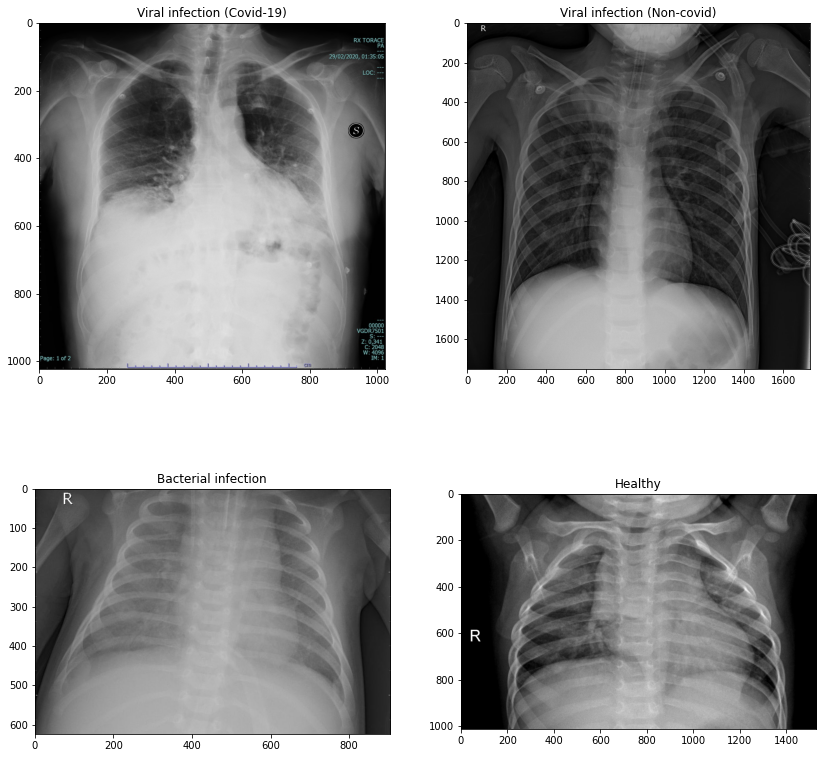

In [17]:
#Getting some sample images

normal = df_train[df_train['Label'] == 'Normal']['X_ray_image_name'].iloc[0]
bacteria = df_train[df_train['Label_1_Virus_category'] == 'bacteria']['X_ray_image_name'].iloc[0]
virus_covid = df_train[df_train['Label_2_Virus_category'] == 'COVID-19']['X_ray_image_name'].iloc[10]
virus_noncovid = df_train[(df_train['Label_2_Virus_category'] != 'COVID-19')
                          &
                          (df_train['Label_1_Virus_category'] == 'Virus')]['X_ray_image_name'].iloc[0]


covid_img = load_img('./Pictures/train/covid-19/{}'.format(virus_covid))
virus_noncovid_img = load_img('./Pictures/train/virus(non-covid)/{}'.format(virus_noncovid))
bacteria_img = load_img('./Pictures/train/bacteria/{}'.format(bacteria))
normal_img = load_img('./Pictures/train/normal/{}'.format(normal))



#Plotting the images

fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (14,14))



ax[0][0].imshow(covid_img)
ax[0][0].set_title('Viral infection (Covid-19)')

ax[0][1].imshow(virus_noncovid_img)
ax[0][1].set_title('Viral infection (Non-covid)')

ax[1][0].imshow(bacteria_img)
ax[1][0].set_title('Bacterial infection')

ax[1][1].imshow(normal_img)
ax[1][1].set_title('Healthy')


plt.show()

# Doing image augmentation

There are only 58 images of COVID-19 labelled X-rays in our dataset which is tragic, so we will attempt to some image augmentation.

Here we will try to artificially generate images so we can have a larger training dataset. First we decide what kind of image transformations will be appropriate, and then proceed with the generation.

In [18]:
#Import libraries

from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, array_to_img

### Horizontal image shifting

In [19]:
#Convert the data to a numpy array

img_array = img_to_array(covid_img)

img_array.shape

(1024, 1024, 3)

In [20]:
#Expand the dimensions by 1 to fit tensorflow's requirements

img_array_exp = np.expand_dims(img_array, 0)

img_array_exp.shape

(1, 1024, 1024, 3)

In [21]:
imagegen = ImageDataGenerator(width_shift_range = 0.2)

iterator = imagegen.flow(img_array_exp)

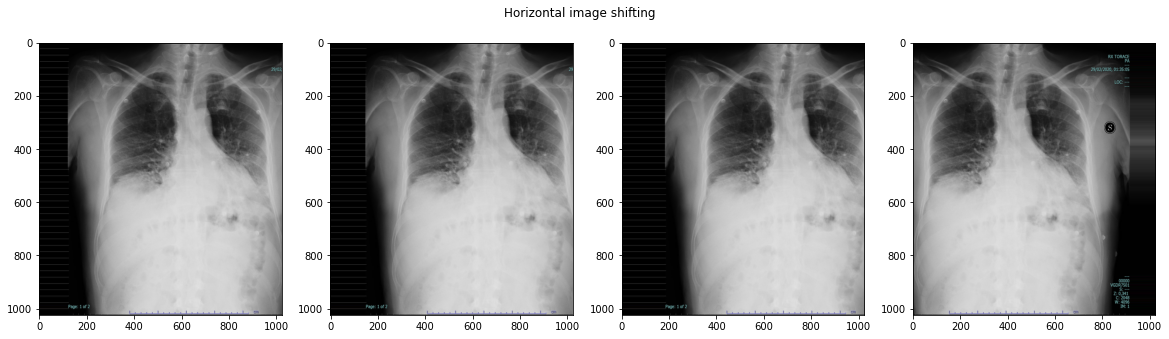

In [22]:
#Plotting a few example images of horizontal shifting

fig, ax = plt.subplots(nrows = 1, ncols =4, 
                           figsize = (20,5))

for i in range(4):

    ax[i].imshow(array_to_img(x = iterator.next()[0],
                             scale = False),
                 aspect = 'auto')
    
fig.suptitle('Horizontal image shifting')
plt.show()

### Vertical image shifting


In [23]:
imagegen = ImageDataGenerator(height_shift_range = 0.2)

iterator = imagegen.flow(img_array_exp)

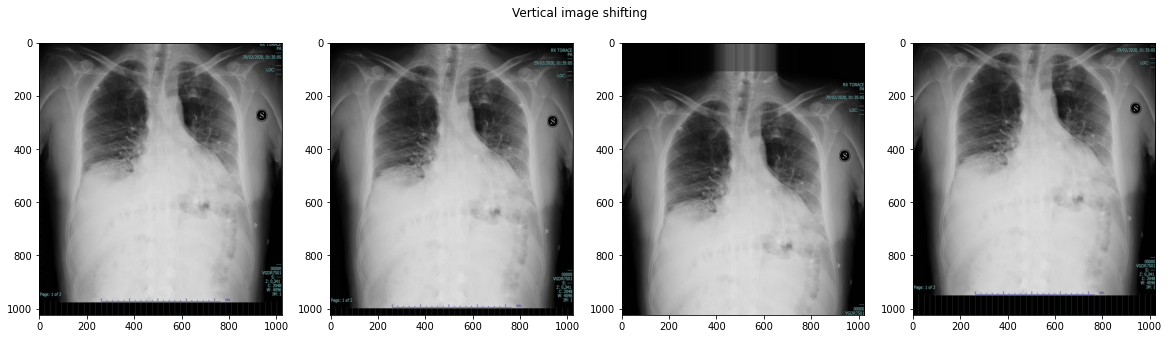

In [24]:
#Plotting a few example images of horizontal shifting

fig, ax = plt.subplots(nrows = 1, ncols =4, 
                           figsize = (20,5))

for i in range(4):

    ax[i].imshow(array_to_img(x = iterator.next()[0],
                             scale = False),
                 aspect = 'auto')
    
fig.suptitle('Vertical image shifting')
plt.show()

### Horizontal flipping:

In [25]:
imagegen = ImageDataGenerator(horizontal_flip = True)

iterator = imagegen.flow(img_array_exp)

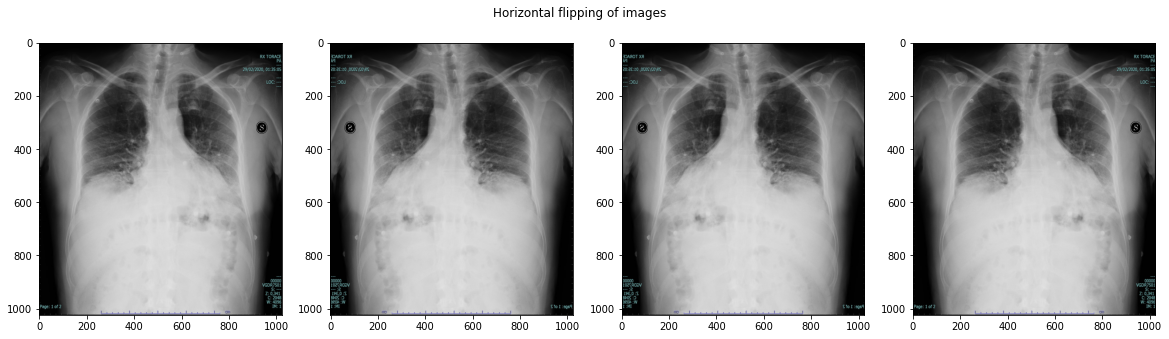

In [26]:
#Plotting a few example images of horizontal shifting

fig, ax = plt.subplots(nrows = 1, ncols =4, 
                           figsize = (20,5))

for i in range(4):

    ax[i].imshow(array_to_img(x = iterator.next()[0],
                             scale = False),
                 aspect = 'auto')
    
fig.suptitle('Horizontal flipping of images')
plt.show()

### Vertical flipping:

Vertical flipping would not be realistic for X-ray images so we exclude that. Therefore we will use the previous 3 image transformations to generate new data. 

# Load images into keras image generators

In [27]:
#Prepare our generator

generator = ImageDataGenerator(width_shift_range = 0.2,
                               height_shift_range = 0.2,
                               horizontal_flip = True)

In [28]:
#Attach generator to the directories

train_generator = generator.flow_from_directory(directory = './Pictures/train',
                                                class_mode = 'categorical',
                                                color_mode = 'grayscale',
                                                batch_size = 16)

test_generator = generator.flow_from_directory(directory = './Pictures/test',
                                                class_mode = 'categorical',
                                                color_mode = 'grayscale')

Found 5276 images belonging to 4 classes.
Found 632 images belonging to 4 classes.


In [29]:
#Old code without image generation, preparing static dataset

from keras.preprocessing import image_dataset_from_directory

training_ds = image_dataset_from_directory(directory = './Pictures/train',
                                           label_mode = 'categorical',
                                           color_mode = 'grayscale',
                                           batch_size = 8)
testing_ds = image_dataset_from_directory(directory = './Pictures/test',
                                           label_mode = 'categorical',
                                           color_mode = 'grayscale')


Found 5276 files belonging to 4 classes.
Found 632 files belonging to 4 classes.


### Preparing class weights for model fitting:

In [30]:
#Put the class counts in to a dictionary:

classes = os.listdir('./Pictures/train')
classes.remove('desktop.ini')

class_count = dict()

for i in classes:
    class_count[i] = len(os.listdir('./Pictures/train/{}'.format(i)))

class_count

{'bacteria': 2536, 'covid-19': 51, 'normal': 1343, 'virus(non-covid)': 1350}

In [31]:
#Compute class weights:

total_sum = sum(class_count.values())

class_weights = {label: 1/(count/total_sum) for label, count in enumerate(class_count.values())}

class_weights_names = {list(class_count.keys())[label]: 1/(count/total_sum) for label, count in enumerate(class_count.values())}

#Check output:

class_weights_names


{'bacteria': 2.082018927444795,
 'covid-19': 103.52941176470588,
 'normal': 3.9314966492926287,
 'virus(non-covid)': 3.911111111111111}

In [32]:
#Weight for covid-19 cases (label 1) is a little high so we can adjust it downwards

class_weights[1] = 20.0

class_weights

{0: 2.082018927444795, 1: 20.0, 2: 3.9314966492926287, 3: 3.911111111111111}

# Constructing the model

### Using Keras Tuner to tune model hyperparameters:

First we define a function that builds a compiled model, which takes in one 'hyperparameter' argument:

In [33]:
def build_model(hp):
    
    #Instantiate model:
    model = keras.Sequential()
    
    #Tune first layer:
    
    filters_choices1 = hp.Choice('filters_stage1', [8,16,32,64])
    
    model.add(Conv2D(filters_choices1, 
                     kernel_size = (5,5), 
                 input_shape = (256,256,1), #Provide input shape for first layer!
                 #kernel_regularizer=keras.regularizers.l1(0.01), #Regularization to prevent overfitting
                 activation = 'relu', 
                 padding = 'same')) #Zero pad the borders 
    
    
    model.add(MaxPool2D(pool_size = (2,2),
                    strides = (2,2) )) #Pooling to accelerate learning

    model.add(Conv2D(filters_choices1,
                     kernel_size = (5,5), 
                     #kernel_regularizer=keras.regularizers.l1(0.01),
                     activation = 'relu',
                     padding = 'valid'))

    model.add(MaxPool2D(pool_size = (2,2),
                    strides = (2,2) )) #Pooling to accelerate learning

    
    filters_choices2 = hp.Choice('filters_stage2', [16,32,64,128])
    model.add(Conv2D(filters_choices2, 
                     kernel_size = (5,5), 
                     #kernel_regularizer=keras.regularizers.l1(0.01),
                     activation = 'relu',
                     padding = 'valid'))
    model.add(Flatten())
    
    dense_choices = hp.Choice('units',[20,40,60,80])
    model.add(Dense(dense_choices, activation = 'relu'))
    
    model.add(Dense(4, activation = 'softmax'))
    
    model.compile(optimizer = Adam(hp.Choice('learning_rate', [0.01,0.001,0.0001,0.00001,0.000001])
                                  ),
                  loss = tf.keras.losses.CategoricalCrossentropy(),
                  metrics = ['accuracy', AUC(), Precision(), Recall()])
    
    return model

We instantiate the tuner, in this case we use the Hyperband algorithm. There are other built-in algorithms available like Bayesian Optimization and Random Search. The Hyperband algorithm quickly discards poor-performing models and runs more epochs for more promising ones:

In [34]:
#Instantiate tuner

tuner = kt.Hyperband(build_model,
                     objective = 'accuracy', 
                     max_epochs = 100,
                     hyperband_iterations = 3,
                     project_name = 'Keras Tuner',
                     directory = 'E:\Project files (Large)\Project 3'
                    )

#Create an early stopping callback to stop model training if loss stagnates

stopper_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

INFO:tensorflow:Reloading Oracle from existing project E:\Project files (Large)\Project 3\Keras Tuner\oracle.json
INFO:tensorflow:Reloading Tuner from E:\Project files (Large)\Project 3\Keras Tuner\tuner0.json


In [79]:
#Begin tuning hyperparameters!

tuner.search(train_generator, 
                     #callbacks = [stopper_callback], #seems to be getting some error with the callback
                     epochs = 50, 
                     class_weight = class_weights)


Search: Running Trial #1

Hyperparameter    |Value             |Best Value So Far 
filters_stage1    |32                |32                
filters_stage2    |128               |128               
units             |80                |80                
learning_rate     |0.0001            |0.0001            
tuner/epochs      |100               |34                
tuner/initial_e...|34                |12                
tuner/bracket     |4                 |4                 
tuner/round       |4                 |3                 
tuner/trial_id    |231fb961b4c0434...|fdd83897a84c31e...

Epoch 35/100
 20/330 [>.............................] - ETA: 41s - loss: 466.7852 - accuracy: 0.2875 - auc: 0.5246 - precision: 0.2875 - recall: 0.2875

KeyboardInterrupt: 

In [35]:
best_params = tuner.get_best_hyperparameters()[0].values

#Print the best parameters found by Hyperband:

print('Best parameters:', '\n')
print('No. of convolution filters in stage 1:', best_params['filters_stage1'])
print('No. of convolution filters in stage 2:', best_params['filters_stage2'])
print('No. of units in second-last Dense layer:', best_params['units'])
print('Base learning rate for Adam optimizer', best_params['learning_rate'])

Best parameters: 

No. of convolution filters in stage 1: 32
No. of convolution filters in stage 2: 128
No. of units in second-last Dense layer: 80
Base learning rate for Adam optimizer 0.0001


### In the case of loading a previously saved model:

In [17]:
# model = load_model('E:\Project files (Large)\Project 3\Model_seven_with_augmentation_tuned')

### Constructing a new model with tuned hyperparameters:

In [36]:
model = tuner.get_best_models()[0]

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 32)      832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 124, 124, 32)      25632     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 58, 58, 128)       102528    
_________________________________________________________________
flatten (Flatten)            (None, 430592)            0         
_________________________________________________________________
dense (Dense)                (None, 80)                3

In [317]:
#Old code from manually hand-picking parameters
'''
model = Sequential()

#Stage 1
model.add(Conv2D(filters = 6, kernel_size = (30,30), 
                 input_shape = (256,256,1), #Provide input shape for first layer!
                 #kernel_regularizer=keras.regularizers.l1(0.01), #Regularization to prevent overfitting
                 activation = 'relu', 
                 padding = 'same'))

model.add(MaxPool2D(pool_size = (2,2),
                    strides = (2,2) )) #Pooling layer to acclerate learning

model.add(Conv2D(filters = 18, kernel_size = (30,30), 
                 #kernel_regularizer=keras.regularizers.l1(0.01),
                 activation = 'relu',
                 padding = 'valid'))

model.add(MaxPool2D(pool_size = (2,2),
                    strides = (2,2) )) 


#Stage 2
model.add(Conv2D(filters = 120, kernel_size = (30,30), 
                 #kernel_regularizer=keras.regularizers.l1(0.01),
                 activation = 'relu',
                 padding = 'valid'))


#Flatten outputs before dense layers

model.add(Flatten())

model.add(Dense(84, activation = 'relu'))


#Dense layer for decision output
model.add(Dense(4, activation = 'softmax'))


#Compile model to prepare it for training

model.compile(optimizer = Adam(learning_rate = 0.001),
              loss = tf.keras.losses.CategoricalCrossentropy(),
             metrics = ['accuracy', AUC(), Precision(), Recall()])

#View the overall architecture of the model

model.summary()

'''

### Creating a scheduler so the learning rate decays as the model learns

Adam already adjusts per-parameter learning rate during training, but the base learning rate can also be set to decay. The base will be the maximum learning rate limit that Adam allocates per parameter. 

In [37]:
#Create a scheduler to adjust learning rate across epochs

#Define a function to apply a time-based reciprocal decay to learning rate
#after 100 epochs

def decay(epoch, lr, decayspeed = 0.1):
    if epoch < 20:
        return lr
    else:
        return lr/(1+(decayspeed*epoch))

#Create a scheduler

from keras.callbacks import LearningRateScheduler

scheduler = LearningRateScheduler(decay)

In [93]:
#Fit the model using augmented images and a scheduler to decay learning rate

history = model.fit(x = train_generator, 
                    epochs = 500, 
                    steps_per_epoch= None,
                    callbacks = scheduler,
                    class_weight = class_weights
                   )

Epoch 1/500
330/330 [==============================] - 41s 125ms/step - loss: 1.7475 - accuracy: 0.7530 - auc: 0.9371 - precision: 0.7720 - recall: 0.7206
Epoch 2/500
330/330 [==============================] - 41s 123ms/step - loss: 1.6858 - accuracy: 0.7576 - auc: 0.9396 - precision: 0.7785 - recall: 0.7250
Epoch 3/500
330/330 [==============================] - 41s 123ms/step - loss: 1.7395 - accuracy: 0.7559 - auc: 0.9388 - precision: 0.7782 - recall: 0.7235
Epoch 4/500
330/330 [==============================] - 41s 125ms/step - loss: 1.6403 - accuracy: 0.7616 - auc: 0.9415 - precision: 0.7804 - recall: 0.7356
Epoch 5/500
330/330 [==============================] - 41s 123ms/step - loss: 1.6023 - accuracy: 0.7663 - auc: 0.9439 - precision: 0.7802 - recall: 0.7455
Epoch 6/500
330/330 [==============================] - 41s 124ms/step - loss: 1.6739 - accuracy: 0.7557 - auc: 0.9406 - precision: 0.7744 - recall: 0.7273
Epoch 7/500
330/330 [==============================] - 41s 125ms/step 

330/330 [==============================] - 41s 124ms/step - loss: 1.3931 - accuracy: 0.7913 - auc: 0.9547 - precision: 0.8012 - recall: 0.7790
Epoch 54/500
330/330 [==============================] - 41s 123ms/step - loss: 1.3834 - accuracy: 0.7904 - auc: 0.9552 - precision: 0.8022 - recall: 0.7777
Epoch 55/500
330/330 [==============================] - 41s 123ms/step - loss: 1.3803 - accuracy: 0.7930 - auc: 0.9554 - precision: 0.8038 - recall: 0.7798
Epoch 56/500
330/330 [==============================] - 41s 124ms/step - loss: 1.3908 - accuracy: 0.7906 - auc: 0.9542 - precision: 0.7984 - recall: 0.7739
Epoch 57/500
330/330 [==============================] - 41s 123ms/step - loss: 1.3830 - accuracy: 0.7883 - auc: 0.9550 - precision: 0.7989 - recall: 0.7771
Epoch 58/500
330/330 [==============================] - 41s 123ms/step - loss: 1.3861 - accuracy: 0.7904 - auc: 0.9542 - precision: 0.8007 - recall: 0.7769
Epoch 59/500
330/330 [==============================] - 41s 124ms/step - loss

330/330 [==============================] - 41s 124ms/step - loss: 1.3940 - accuracy: 0.7828 - auc: 0.9529 - precision: 0.7942 - recall: 0.7701
Epoch 106/500
330/330 [==============================] - 41s 125ms/step - loss: 1.3619 - accuracy: 0.7921 - auc: 0.9553 - precision: 0.8012 - recall: 0.7799
Epoch 107/500
330/330 [==============================] - 41s 123ms/step - loss: 1.3767 - accuracy: 0.7894 - auc: 0.9546 - precision: 0.8007 - recall: 0.7773
Epoch 108/500
330/330 [==============================] - 41s 124ms/step - loss: 1.3771 - accuracy: 0.7877 - auc: 0.9550 - precision: 0.7998 - recall: 0.7739
Epoch 109/500
330/330 [==============================] - 41s 126ms/step - loss: 1.3809 - accuracy: 0.7928 - auc: 0.9557 - precision: 0.8044 - recall: 0.7771
Epoch 110/500
330/330 [==============================] - 41s 123ms/step - loss: 1.3663 - accuracy: 0.7932 - auc: 0.9556 - precision: 0.8030 - recall: 0.7811
Epoch 111/500
330/330 [==============================] - 41s 124ms/step 

330/330 [==============================] - 41s 123ms/step - loss: 1.3370 - accuracy: 0.7909 - auc: 0.9559 - precision: 0.7999 - recall: 0.7765
Epoch 158/500
330/330 [==============================] - 41s 123ms/step - loss: 1.3671 - accuracy: 0.7949 - auc: 0.9556 - precision: 0.8039 - recall: 0.7815
Epoch 159/500
330/330 [==============================] - 41s 124ms/step - loss: 1.3882 - accuracy: 0.7879 - auc: 0.9538 - precision: 0.8000 - recall: 0.7739
Epoch 160/500
330/330 [==============================] - 41s 125ms/step - loss: 1.3636 - accuracy: 0.7932 - auc: 0.9547 - precision: 0.8026 - recall: 0.7790
Epoch 161/500
330/330 [==============================] - 40s 123ms/step - loss: 1.3693 - accuracy: 0.7898 - auc: 0.9556 - precision: 0.8007 - recall: 0.7752
Epoch 162/500
330/330 [==============================] - 41s 124ms/step - loss: 1.3788 - accuracy: 0.7926 - auc: 0.9547 - precision: 0.8022 - recall: 0.7794
Epoch 163/500
330/330 [==============================] - 41s 124ms/step 

330/330 [==============================] - 41s 124ms/step - loss: 1.3728 - accuracy: 0.7860 - auc: 0.9546 - precision: 0.7962 - recall: 0.7710
Epoch 210/500
330/330 [==============================] - 41s 123ms/step - loss: 1.3683 - accuracy: 0.7892 - auc: 0.9548 - precision: 0.8000 - recall: 0.77778s - loss: 1.3917 - 
Epoch 211/500
330/330 [==============================] - 41s 124ms/step - loss: 1.3702 - accuracy: 0.7906 - auc: 0.9553 - precision: 0.8007 - recall: 0.7750
Epoch 212/500
330/330 [==============================] - 41s 123ms/step - loss: 1.3515 - accuracy: 0.7843 - auc: 0.9559 - precision: 0.7956 - recall: 0.7693
Epoch 213/500
330/330 [==============================] - 41s 124ms/step - loss: 1.3726 - accuracy: 0.7843 - auc: 0.9545 - precision: 0.7955 - recall: 0.7722
Epoch 214/500
330/330 [==============================] - 41s 124ms/step - loss: 1.3310 - accuracy: 0.7951 - auc: 0.9569 - precision: 0.8039 - recall: 0.7796
Epoch 215/500
330/330 [=============================

330/330 [==============================] - 41s 123ms/step - loss: 1.3983 - accuracy: 0.7879 - auc: 0.9548 - precision: 0.7996 - recall: 0.7739
Epoch 261/500
330/330 [==============================] - 41s 125ms/step - loss: 1.3606 - accuracy: 0.7934 - auc: 0.9554 - precision: 0.8020 - recall: 0.7786
Epoch 262/500
330/330 [==============================] - 41s 123ms/step - loss: 1.3679 - accuracy: 0.7868 - auc: 0.9555 - precision: 0.7986 - recall: 0.7705
Epoch 263/500
330/330 [==============================] - 41s 123ms/step - loss: 1.3717 - accuracy: 0.7881 - auc: 0.9552 - precision: 0.7992 - recall: 0.7731
Epoch 264/500
330/330 [==============================] - 41s 125ms/step - loss: 1.3838 - accuracy: 0.7873 - auc: 0.9548 - precision: 0.7981 - recall: 0.7748
Epoch 265/500
330/330 [==============================] - 41s 123ms/step - loss: 1.3576 - accuracy: 0.7938 - auc: 0.9557 - precision: 0.8029 - recall: 0.7792
Epoch 266/500
330/330 [==============================] - 41s 123ms/step 

Epoch 312/500
330/330 [==============================] - 41s 124ms/step - loss: 1.3700 - accuracy: 0.7900 - auc: 0.9548 - precision: 0.7996 - recall: 0.7788
Epoch 313/500
330/330 [==============================] - 41s 124ms/step - loss: 1.3452 - accuracy: 0.7949 - auc: 0.9561 - precision: 0.8049 - recall: 0.7782
Epoch 314/500
330/330 [==============================] - 41s 124ms/step - loss: 1.3672 - accuracy: 0.7947 - auc: 0.9552 - precision: 0.8062 - recall: 0.7807
Epoch 315/500
330/330 [==============================] - 41s 124ms/step - loss: 1.3883 - accuracy: 0.7906 - auc: 0.9547 - precision: 0.8033 - recall: 0.7773
Epoch 316/500
330/330 [==============================] - 41s 124ms/step - loss: 1.3736 - accuracy: 0.7892 - auc: 0.9551 - precision: 0.7988 - recall: 0.7743
Epoch 317/500
330/330 [==============================] - 41s 124ms/step - loss: 1.3757 - accuracy: 0.7906 - auc: 0.9543 - precision: 0.7998 - recall: 0.7786
Epoch 318/500
330/330 [==============================] - 4

330/330 [==============================] - 41s 124ms/step - loss: 1.3780 - accuracy: 0.7849 - auc: 0.9543 - precision: 0.7970 - recall: 0.77185s - loss: 1.3563 - accuracy: 0.7872 - auc: 0
Epoch 365/500
330/330 [==============================] - 41s 123ms/step - loss: 1.3779 - accuracy: 0.7911 - auc: 0.9551 - precision: 0.8004 - recall: 0.7758
Epoch 366/500
330/330 [==============================] - 41s 124ms/step - loss: 1.3829 - accuracy: 0.7860 - auc: 0.9545 - precision: 0.7969 - recall: 0.7695
Epoch 367/500
330/330 [==============================] - 41s 123ms/step - loss: 1.3631 - accuracy: 0.7875 - auc: 0.9559 - precision: 0.7991 - recall: 0.7752
Epoch 368/500
330/330 [==============================] - 41s 124ms/step - loss: 1.3918 - accuracy: 0.7898 - auc: 0.9537 - precision: 0.8020 - recall: 0.7779
Epoch 369/500
330/330 [==============================] - 41s 125ms/step - loss: 1.3663 - accuracy: 0.7919 - auc: 0.9557 - precision: 0.8026 - recall: 0.7805
Epoch 370/500
330/330 [====

Epoch 416/500
330/330 [==============================] - 41s 124ms/step - loss: 1.3809 - accuracy: 0.7862 - auc: 0.9542 - precision: 0.7961 - recall: 0.7695
Epoch 417/500
330/330 [==============================] - 41s 125ms/step - loss: 1.3849 - accuracy: 0.7908 - auc: 0.9549 - precision: 0.8004 - recall: 0.7784
Epoch 418/500
330/330 [==============================] - 41s 124ms/step - loss: 1.3688 - accuracy: 0.7923 - auc: 0.9554 - precision: 0.8029 - recall: 0.7784
Epoch 419/500
330/330 [==============================] - 41s 124ms/step - loss: 1.3911 - accuracy: 0.7890 - auc: 0.9558 - precision: 0.8011 - recall: 0.7763
Epoch 420/500
330/330 [==============================] - 41s 124ms/step - loss: 1.3943 - accuracy: 0.7892 - auc: 0.9545 - precision: 0.7971 - recall: 0.7758
Epoch 421/500
330/330 [==============================] - 41s 124ms/step - loss: 1.3766 - accuracy: 0.7849 - auc: 0.9544 - precision: 0.7977 - recall: 0.7722
Epoch 422/500
330/330 [==============================] - 4

330/330 [==============================] - 41s 125ms/step - loss: 1.3836 - accuracy: 0.7890 - auc: 0.9545 - precision: 0.7986 - recall: 0.7746
Epoch 469/500
330/330 [==============================] - 41s 123ms/step - loss: 1.3544 - accuracy: 0.7932 - auc: 0.9558 - precision: 0.8046 - recall: 0.7805
Epoch 470/500
330/330 [==============================] - 41s 123ms/step - loss: 1.3461 - accuracy: 0.7945 - auc: 0.9558 - precision: 0.8033 - recall: 0.7826
Epoch 471/500
330/330 [==============================] - 41s 124ms/step - loss: 1.3874 - accuracy: 0.7889 - auc: 0.9542 - precision: 0.8003 - recall: 0.7763
Epoch 472/500
330/330 [==============================] - 41s 124ms/step - loss: 1.3581 - accuracy: 0.7870 - auc: 0.9555 - precision: 0.7987 - recall: 0.7710
Epoch 473/500
330/330 [==============================] - 41s 123ms/step - loss: 1.3633 - accuracy: 0.7866 - auc: 0.9556 - precision: 0.7966 - recall: 0.7733
Epoch 474/500
330/330 [==============================] - 41s 124ms/step 

In [94]:
#Save model

model.save('E:\Project files (Large)\Project 3\Model_seven_with_augmentation_tuned', overwrite = False)

[WARNING] E:\Project files (Large)\Project 3\Model_seven_with_augmentation_tuned already exists - overwrite? [y/n]y
[TIP] Next time specify overwrite=True!
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: E:\Project files (Large)\Project 3\Model_seven_with_augmentation_tuned\assets


In [17]:
#Save history file:

'''
import pickle

with open('./Models/Model_seven_with_augmentation_tuned/history.p', 'wb') as outfile:
    pickle.dump(history, outfile)
'''

"\nimport pickle\n\nwith open('./Models/Model_six_with_augmentation/history.p', 'wb') as outfile:\n    pickle.dump(mainhistory, outfile)\n"

In [14]:
#Unlock this cell if loading previous history file:
'''
import pickle

#Load main epoch history


with open('./Models/Model_seven_with_augmentation_tuned/history.p', 'rb') as readingfile:
    mainhistory = pickle.load(readingfile)
 
'''

## Evaluate model

In [99]:
#Evaluate against test data:

evaluate = model.evaluate(testing_ds)

20/20 [==============================] - 2s 91ms/step - loss: 0.9888 - accuracy: 0.7595 - auc: 0.8909 - precision: 0.7716 - recall: 0.7215


In [102]:
#Metrics contained in our training history file:

history.history.keys()

dict_keys(['loss', 'accuracy', 'auc', 'precision', 'recall', 'lr'])

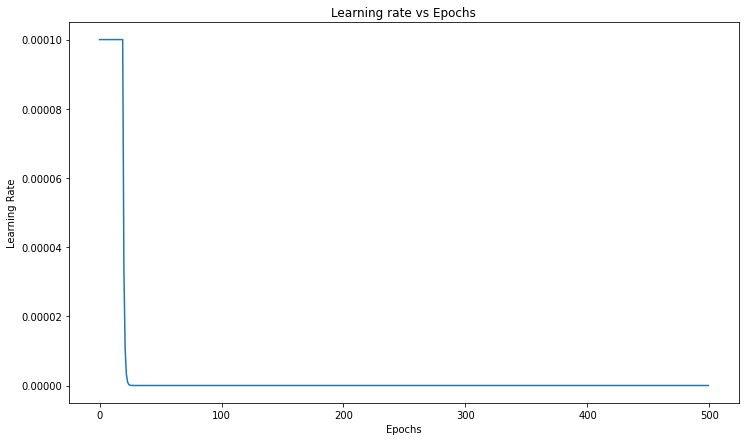

In [103]:
#Plot the learning rate over epochs:

plt.figure(figsize = (12,7))

plt.plot(history.history['lr'])

plt.title('Learning rate vs Epochs')
plt.ylabel('Learning Rate')
plt.xlabel('Epochs')
plt.show()

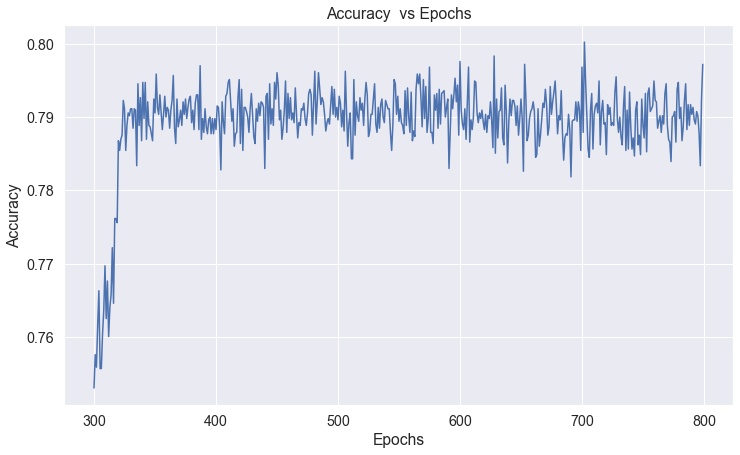

In [133]:
#Plot model accuracy over epochs:

plt.figure(figsize = (12,7))

sns.lineplot(y = history.history['accuracy'], x = np.arange(300,800)) #History under 300 epochs are in the tuner, can't seem to access them

plt.title('Accuracy  vs Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.show()

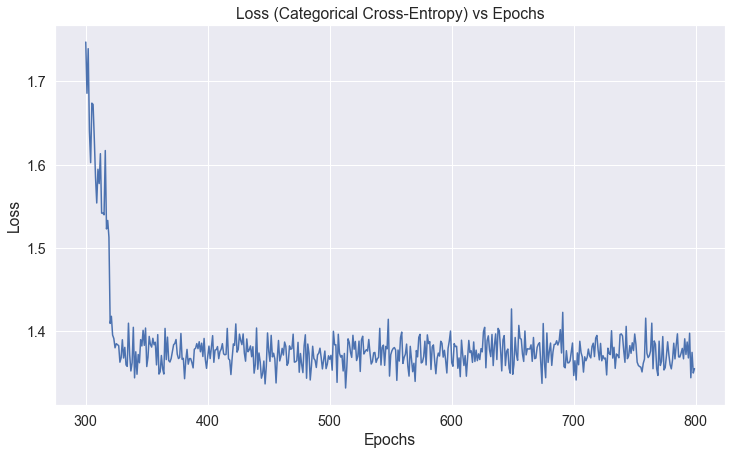

In [134]:
#Plot loss function over epochs:

plt.figure(figsize = (12,7))

sns.lineplot(y = history.history['loss'], x = np.arange(300,800)) #History under 300 epochs are in the tuner, can't seem to access them

plt.title('Loss (Categorical Cross-Entropy) vs Epochs')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.show()

### Confusion matrix and classification report (Train):

In [124]:
#Prepare a train generator with shuffle = False

train_generator = generator.flow_from_directory(directory = './Pictures/train',
                                                class_mode = 'categorical',
                                                color_mode = 'grayscale',
                                               shuffle = False)
train_predict = model.predict(train_generator)

train_predicted_classes = np.argmax(train_predict, axis = 1)
train_true_classes = train_generator.classes

Found 5276 images belonging to 4 classes.


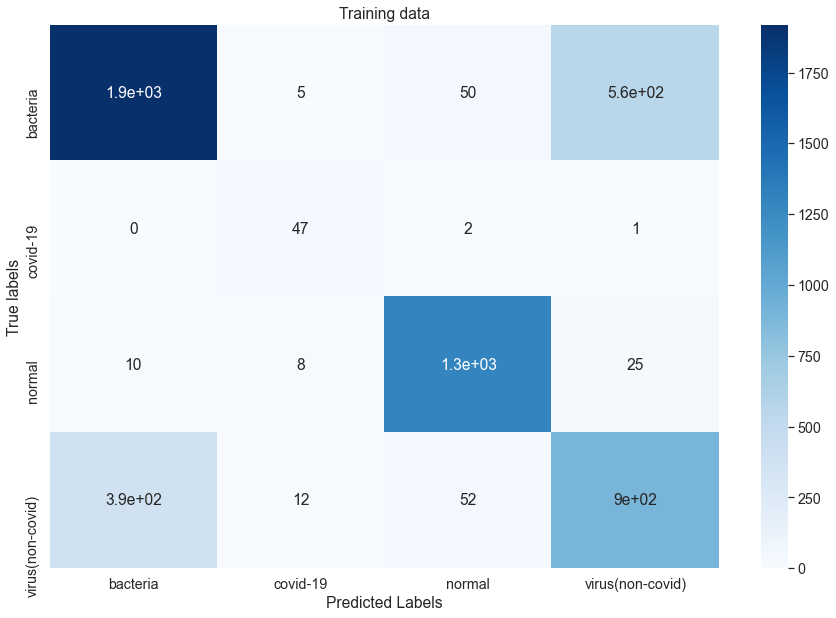

In [125]:
cm = confusion_matrix(train_true_classes, train_predicted_classes)

df_cm = pd.DataFrame(cm,
                     index = class_count.keys(),
                     columns = class_count.keys())

plt.figure(figsize = (15,10))

sns.set(font_scale = 1.3)

sns.heatmap(df_cm, annot = True, cmap = 'Blues')

plt.xlabel('Predicted Labels')
plt.ylabel('True labels')

plt.title('Training data')
plt.show()

In [126]:
from sklearn.metrics import classification_report

print(classification_report(train_true_classes, train_predicted_classes, target_names = class_count.keys()))

                  precision    recall  f1-score   support

        bacteria       0.83      0.76      0.79      2535
        covid-19       0.65      0.94      0.77        50
          normal       0.93      0.97      0.95      1342
virus(non-covid)       0.60      0.67      0.63      1349

        accuracy                           0.79      5276
       macro avg       0.75      0.83      0.79      5276
    weighted avg       0.79      0.79      0.79      5276



### Confusion matrix and classification report (Test):

In [127]:
#Prepare a test generator with shuffle = False so we can identify the true/predicted classes

test_generator = generator.flow_from_directory(directory = './Pictures/test',
                                                class_mode = 'categorical',
                                                color_mode = 'grayscale',
                                               shuffle = False)

predictions = model.predict(test_generator)

predicted_classes = np.argmax(predictions, axis = 1)
true_classes = test_generator.classes

Found 632 images belonging to 4 classes.


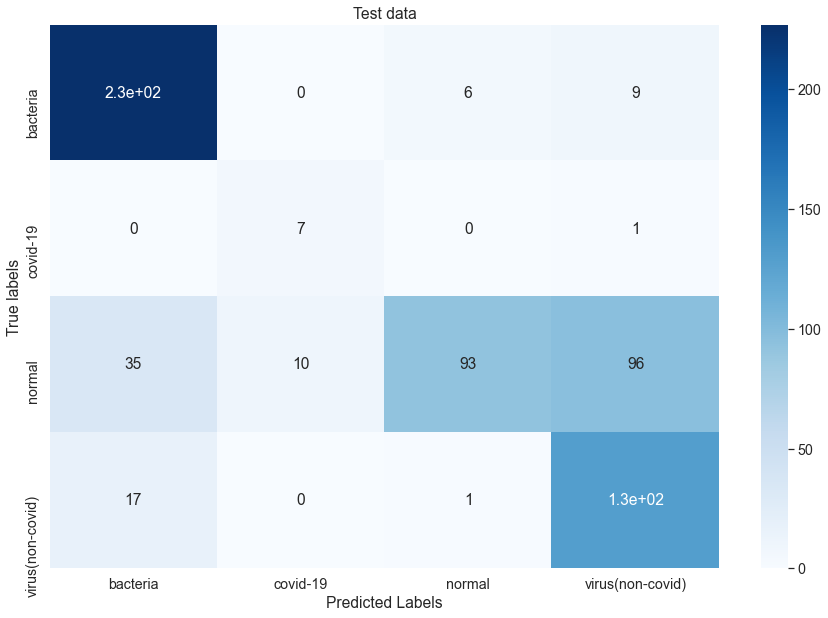

In [128]:
cm = confusion_matrix(true_classes, predicted_classes)

df_cm = pd.DataFrame(cm,
                     index = class_count.keys(),
                     columns = class_count.keys())

plt.figure(figsize = (15,10))

sns.set(font_scale = 1.3)

sns.heatmap(df_cm, annot = True, cmap = 'Blues')

plt.xlabel('Predicted Labels')
plt.ylabel('True labels')

plt.title('Test data')



plt.show()

In [129]:
from sklearn.metrics import classification_report

print(classification_report(true_classes, predicted_classes, target_names = class_count.keys()))

                  precision    recall  f1-score   support

        bacteria       0.81      0.94      0.87       242
        covid-19       0.41      0.88      0.56         8
          normal       0.93      0.40      0.56       234
virus(non-covid)       0.55      0.88      0.68       148

        accuracy                           0.72       632
       macro avg       0.68      0.77      0.67       632
    weighted avg       0.79      0.72      0.71       632



The model 